In [219]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import SQcircuit as sq
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import importlib
import scipy as sp

%matplotlib ipympl
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })
plt.rcParams['text.usetex'] = False
importlib.reload(sq_ext)
importlib.reload(sq)
importlib.reload(figs)
np.set_printoptions(linewidth=300, formatter={'float': '{:.12f}'.format})
# np.set_printoptions(linewidth=200, formatter={'float': '{:.1e}'.format})

In [220]:
nH = 1e-9
fF = 1e-15
GHz = 1e9
h    = 6.626e-34
e0   = 1.602e-19
Φ_0 = h/(2*e0)

In [259]:
n_eig  = 5
n_plot = 20
param_name = '\\Delta'
param_values = np.geomspace(1e-4, 1e-1, n_plot)
Δ_values = param_values

N_elements = 2
basis_states = [(0,0), (0,1), (1,0), (1,1)]
max_excitations_mediating_states=4
mediating_states = sq_ext.generate_mediating_states(N_elements, basis_states, max_excitations_mediating_states)
labels_low = [f'({i},{j})' for i, j in basis_states]
labels_high = [f'({i},{j})' for i, j in mediating_states]

n_eig_extra_low = 2

In [260]:
C, CJ, Csh, Lq, Lr, _, EJ = sq_ext.get_experimental_parameters('qubit_2', return_effective=False)
φ_ext=0.5

## Qubit - Cavity 4x4 effective Hamiltonian

In [326]:
Pauli_p1 = []
Pauli_p2 = []
Pauli_SWT = []
ω_f_0      = np.zeros(len(Δ_values))
ω_r_0      = np.zeros(len(Δ_values))
g_r_limit  = np.zeros(len(Δ_values))
g_fq_limit = np.zeros(len(Δ_values))
g_xx_pert  = np.zeros(len(Δ_values))
g_zz_pert  = np.zeros(len(Δ_values))
g_yy_pert  = np.zeros(len(Δ_values))
X          = np.zeros(len(Δ_values))

for i, Δ in enumerate(Δ_values):
    C_F_eff, C_R_eff = sq_ext.C_CJ_Csh_to_CF_CR_eff(C, CJ, Csh)
    L_F_eff, L_R_eff, L_C_eff = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq, Lr, Δ)
    
    fluxonium = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, Lq=L_F_eff, Δ=Δ, φ_ext=φ_ext)
    resonator = sq_ext.sq_resonator(L_R_eff=L_R_eff, C_R_eff=C_R_eff, Δ=Δ)
    
    H_0, H   = sq_ext.hamiltonian_qubit(Lq=L_F_eff, Lr=Lr, fluxonium = fluxonium, resonator = resonator, Δ=Δ, return_H_0=True)
    
    Hf = fluxonium.hamiltonian()
    Hr = resonator.hamiltonian()
    
    ψ0_f         = sq_ext.diag(Hf, n_eig, solver='numpy', real=True)[1]
    ψ0_r         = sq_ext.diag(Hr, n_eig, solver='numpy', real=True)[1]
    
    ψ_0_low = [ qt.tensor(qt.Qobj(ψ0_f[:,i]), qt.Qobj(ψ0_r[:,j]))  for i, j in basis_states]
    ψ_0_high = [ qt.tensor(qt.Qobj(ψ0_f[:,i]), qt.Qobj(ψ0_r[:,j]))  for i, j in mediating_states]
    
    H_eff_p1  = sq_ext.H_eff_p1_large (ψ_0_low, H=H, real=True, remove_ground=True)

    V = H-H_0
    
    E_0_ψ_0_low  = [ np.real((ψ_0_i.dag() * H_0 * ψ_0_i).data[0,0])/2/np.pi/GHz for ψ_0_i in ψ_0_low]
    E_0_ψ_0_high = [ np.real((ψ_0_i.dag() * H_0 * ψ_0_i).data[0,0])/2/np.pi/GHz for ψ_0_i in ψ_0_high]

    H_eff_p2, H_eff_p2_decomposed  =  sq_ext.H_eff_p2_decomposed(ψ_0_low, ψ_0_high, E_0_ψ_0_low, E_0_ψ_0_high, V,  remove_ground=True)

    E_0  = sq_ext.diag(H_0  , n_eig=len(ψ_0_low)+n_eig_extra_low, out='GHz', solver='scipy')[0]
    E, ψ = sq_ext.diag(H  , n_eig=len(ψ_0_low)+n_eig_extra_low, out='GHz', solver='Qutip', qObj=True)
    subspace_indices = sq_ext.find_close_indices(E_0_ψ_0_low,E_0)
    ψ_low = ψ[subspace_indices]
    E_low = E[subspace_indices]
    
    H_eff_SWT = sq_ext.H_eff_SWT_large(ψ_0_low, ψ_low, E_low, remove_ground=True)
    
    Pauli_p1.append(sq_ext.decomposition_in_pauli_4x4   (H_eff_p1, print_pretty=False))
    Pauli_p2.append(sq_ext.decomposition_in_pauli_4x4   (H_eff_p1+H_eff_p2, print_pretty=False))
    Pauli_SWT.append(sq_ext.decomposition_in_pauli_4x4  (H_eff_SWT, print_pretty=False))
    
    fluxonium.diag(3);
    resonator.diag(3);
    omega_f  = fluxonium.efreqs[1]-fluxonium.efreqs[0]
    omega_f2 = fluxonium.efreqs[2]-fluxonium.efreqs[1]
    omega_r  = resonator.efreqs[1]-resonator.efreqs[0]
       
    Φ_f = fluxonium.flux_op(0, basis='eig')
    Φ_r = resonator.flux_op(0, basis='eig')
    g_xx_pert[i] = 1 / (L_C_eff*nH)  *  (Φ_f[0,1]*Φ_r[0,1]/(2*np.pi*GHz)) 
    g_zz_pert[i] =   ( (1 / (L_C_eff*nH) )**2   * ( 
                    Φ_r[1,2]**2 * Φ_f[0,1]**2/(omega_f+omega_r) +
                    Φ_r[0,1]**2 * Φ_f[1,2]**2/(omega_f+omega_r) +
                   -Φ_r[1,2]**2 * Φ_f[1,2]**2/(omega_f+omega_r) +
                    Φ_r[1,2]**2 * Φ_f[0,1]**2/(omega_f-omega_r) +
                    Φ_r[0,1]**2 * Φ_f[1,2]**2/(omega_r-omega_f2)  
                     )/ (2*np.pi*GHz)**2) / 4
    X[i] = g_zz_pert[i] + g_xx_pert[i]**2 * ((omega_f-omega_r)**-1 + (omega_f+omega_r)**-1)
    ω_f_0[i] = omega_f
    ω_r_0[i] = omega_r
    
    # Analytic estimation of coupling
    E_L_f = sq_ext.L_to_EL(L_F_eff)
    V_fluxonium =  lambda φ: E_L_f*φ**2/2 - EJ*GHz*np.cos(φ+np.pi)
    φ_min = sp.optimize.minimize_scalar(V_fluxonium).x
    
    Φ_f_fq_limit_01 = (Φ_0 / (2 * np.pi)) * φ_min / np.sqrt(sq.hbar) 
    Φ_f_r_limit_01  = np.sqrt(0.5*np.sqrt((L_F_eff * nH)/(C_F_eff * fF)))
    Φ_r_01 = np.sqrt(0.5*np.sqrt((L_R_eff * nH)/(C_R_eff * fF)))
    
    g_fq_limit[i] = 1/(L_C_eff * nH) * Φ_f_fq_limit_01 * Φ_r_01  /2 / np.pi / GHz
    g_r_limit[i] =  1/(L_C_eff * nH) * Φ_f_r_limit_01 * Φ_r_01 /2 / np.pi / GHz
    
Pauli_p1  = np.array(Pauli_p1)
Pauli_p2  = np.array(Pauli_p2)
Pauli_SWT = np.array(Pauli_SWT)

# Pauli_p1 = Pauli_p1- Pauli_p1[0,:]
# Pauli_p2 = Pauli_p2- Pauli_p2[0,:]
# Pauli_SWT = Pauli_SWT- Pauli_SWT[0,:]


C:\Users\gabri\AppData\Local\Temp\ipykernel_13348\965416365.py:60: ComplexWarning: Casting complex values to real discards the imaginary part
  g_xx_pert[i] = 1 / (L_C_eff*nH)  *  (Φ_f[0,1]*Φ_r[0,1]/(2*np.pi*GHz))
C:\Users\gabri\AppData\Local\Temp\ipykernel_13348\965416365.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  g_zz_pert[i] =   ( (1 / (L_C_eff*nH) )**2   * (


C:\Users\gabri\AppData\Local\Temp\ipykernel_13348\1375211679.py:22: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "*" (-> marker='*'). The keyword argument will take precedence.
  ax1.plot(Δ_values, g_xx_pert , '*', color = colors[0], marker='o', markersize='4')
C:\Users\gabri\AppData\Local\Temp\ipykernel_13348\1375211679.py:23: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "*" (-> marker='*'). The keyword argument will take precedence.
  ax1.plot(Δ_values, g_zz_pert , '*', color = colors[2], marker='o', markersize='4')


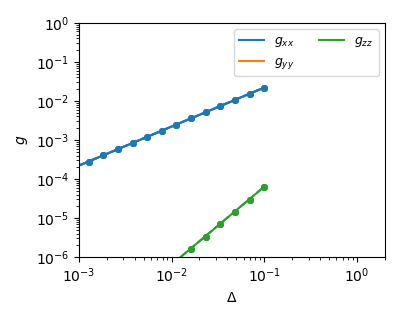

In [327]:
fig, ax1 = plt.subplots(figsize =np.array([5,4])*0.8, dpi=100)
linestyles = ['-', '--','-' ]
colors = figs.generate_colors_from_colormap(10, 'tab10')
set_label  = True
for i, Pauli in enumerate([Pauli_p1, Pauli_p2, Pauli_SWT]):
    # if i==0 or i==2:
    # if i==0 or i==1:
    #     continue

    σxσx = np.abs(Pauli[:, 1,1])
    σyσy = np.abs(Pauli[:, 2,2])
    σzσz = np.abs(Pauli[:, 3,3])
    ωf = np.abs(Pauli[:, 0,-1])
    ωr = np.abs(Pauli[:, -1,0])

    ax1.plot(Δ_values, σxσx, color = colors[0], linestyle=linestyles[i], label = r'$g_{xx}$')
    ax1.plot(Δ_values, σyσy, color = colors[1], linestyle=linestyles[i], label = r'$g_{yy}$')
    ax1.plot(Δ_values, σzσz, color = colors[2], linestyle=linestyles[i], label = r'$g_{zz}$')

    # ax1.plot(Δ_values, g_fq_limit, 'x', color = colors[0], label = 'g_{xx}, fluxon', markersize='2')
    # ax1.plot(Δ_values, g_r_limit , 's', color = colors[0], label = 'g_{xx}, plasmon', markersize='2')
    ax1.plot(Δ_values, g_xx_pert , '*', color = colors[0], marker='o', markersize='4')
    ax1.plot(Δ_values, g_zz_pert , '*', color = colors[2], marker='o', markersize='4')
    # ax1.plot(Δ_values, g_xx_pert * g_zz_pert , '*', color = colors[1],  markersize='4')

    if set_label:
        set_label =False
        ax1.legend(ncol=2, fontsize=9)

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim([1e-6,1e0])
ax1.set_xlim([1e-3,2])
ax1.set_ylabel('$g$')
ax1.set_xlabel('$\Delta$')

# fig.suptitle(r' --- P1 $\quad$ - - P2 $\quad$ $\cdots$ SWT')
fig.tight_layout()
# figs.export('g_H_eff_vs_Delta.pdf', fig)
fig.show()

In [328]:
omega_q

array([0.000000000000, 0.000000000048, 0.000000000146, 0.000000000349, 0.000000000769, 0.000000001639, 0.000000003440, 0.000000007165, 0.000000014873, 0.000000030822, 0.000000063822, 0.000000132103, 0.000000273387, 0.000000565722, 0.000001170596, 0.000002422139, 0.000005011643, 0.000010369212,
       0.000021452742, 0.000044377446])

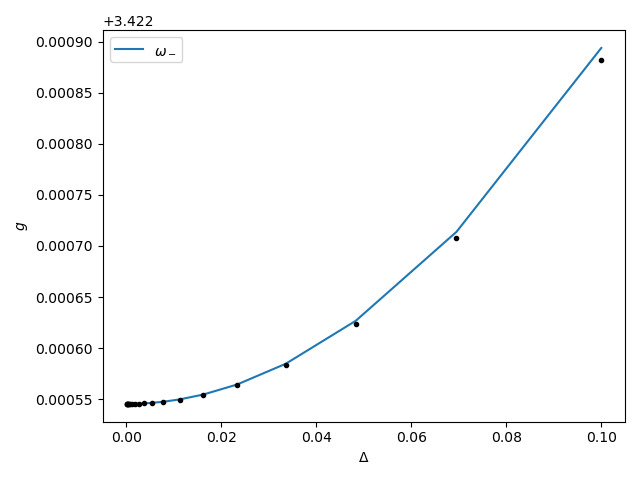

In [379]:
fig, ax = plt.subplots()

omega_f = 2 * np.abs(Pauli[:, -1, 0])
omega_r = 2 * np.abs(Pauli[:, 0,-1])

ax.plot(Δ_values, omega_f, label='$\omega_-$')
ax.plot(Δ_values, ω_f_0  - X, '.k')

# ax.plot(Δ_values, omega_r, label='$\omega_-$')
# ax.plot(Δ_values, ω_r_0 -X/2  , '.r')


# ax.set_yscale('log')
# ax.set_xscale('log')
# ax.set_ylim([1e-6,1e0])
# ax.set_xlim([1e-3,2])
ax.set_ylabel('$g$')
ax.set_xlabel('$\Delta$')
ax.legend()

fig.tight_layout()
fig.show()

In [218]:
omega_r / (1/2 * Pauli[:, 3,3] + 1/8* Pauli[:, 1,1]**2* ( +(omega_f-omega_r)**-1 + (omega_f+omega_r)**-1))

C:\Users\gabri\AppData\Local\Temp\ipykernel_13348\455432140.py:1: RuntimeWarning: invalid value encountered in divide
  omega_r / (1/2 * Pauli[:, 3,3] + 1/8* Pauli[:, 1,1]**2* ( +(omega_f-omega_r)**-1 + (omega_f+omega_r)**-1))


array([nan, 1.380651777224, 1.363436829924, 1.334566441428, 1.318275067540, 1.302784500504, 1.288634392492, 1.272145264902, 1.258023889106, 1.243865589674, 1.229935331647, 1.216642194689, 1.204583638927, 1.192744285638, 1.180822075578, 1.169700437209, 1.159151069687, 1.148852684445, 1.139214552288,
       1.129814995716, 1.120783302513, 1.112216032921, 1.104106655390, 1.096339752502, 1.088955891223, 1.081813546005, 1.075090549432, 1.068643295973, 1.062595491538, 1.056805154740, 1.051227698983, 1.046035891908, 1.041028574528, 1.036315511798, 1.031789598663, 1.027539204435, 1.023494228207,
       1.019650176845, 1.016012651329, 1.012543644900, 1.009273947412, 1.006176603488, 1.003242448607, 1.000453237818, 0.997811572206, 0.995322883844, 0.992962465887, 0.990722161499, 0.988604295319, 0.986600488284, 0.984701354189, 0.982912505815, 0.981218811790, 0.979610378362, 0.978097332044,
       0.976663016794, 0.975305083010, 0.974024345439, 0.972811887965, 0.971666589315, 0.970584392386, 0.96956

In [112]:
g_xx_pert * g_zz_pert / σyσy

C:\Users\gabri\AppData\Local\Temp\ipykernel_13348\1401067793.py:1: RuntimeWarning: divide by zero encountered in divide
  g_xx_pert * g_zz_pert / σyσy


array([inf, 0.188927823445, 0.123164544200, 9.942185009702, 0.371494349381, 1.847826024826, 2.902678926303, 4.146552122283, 1.877121055585, 11.275303791339, 6.544001223210, 2.810756897078, 6.767605407983, 13.036816292373, 19.481902573367, 13.976555608310, 4.296294853551, 7.691453663042,
       7.340418748061, 4.121679671053, 11.301644773600, 4.555580488735, 3.570212530747, 5.195156238523, 9.668627297806, 10.753843709590, 21.092805547338, 11.284629474456, 88.210963456448, 21.495031977966, 14.331468887088, 14.087423821155, 14.733351313488, 14.610569569107, 14.936416366789,
       15.016320143835, 15.514737057333, 14.545686722603, 12.969673578139, 14.233381131695, 14.161317221397, 13.510699086577, 14.454490716325, 13.819123341859, 14.244261773008, 14.752012982081, 14.373224304219, 14.280569635850, 14.101966132799, 14.205449618554, 14.327309558747, 14.331994293349,
       14.264106406151, 14.151793173713, 14.179957730451, 14.290967861739, 14.219956593317, 14.224706853089, 14.157685707342, 

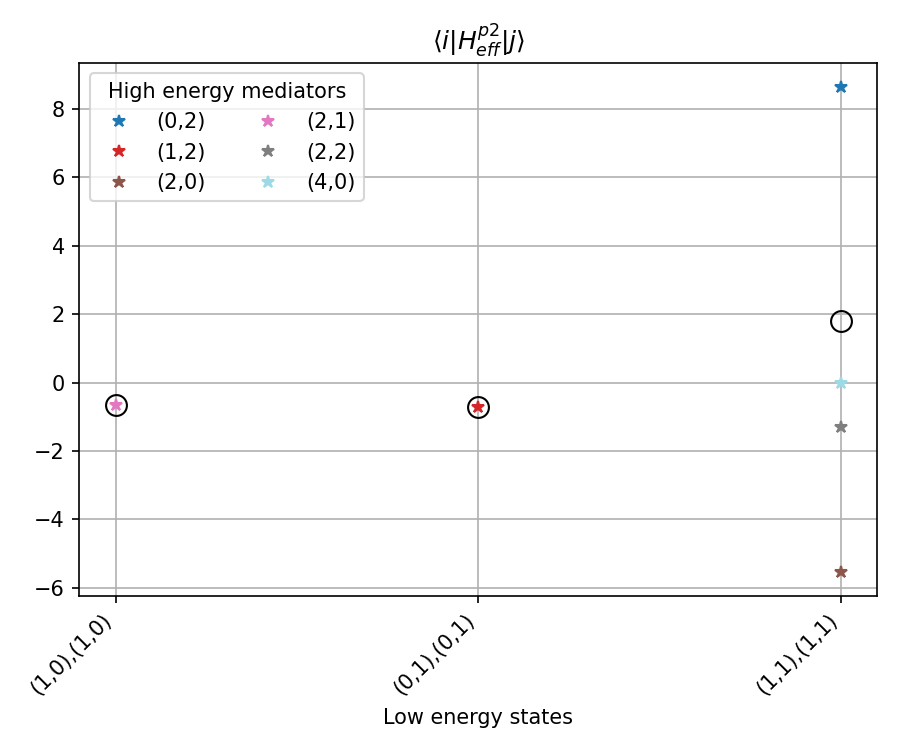

In [63]:
sq_ext.plot_second_order_contributions(H_eff_p2_decomposed, labels_low, labels_high,figsize=np.array([6, 5]) * 1 ,threshold =1e-4)

## Qubit 2x2 effective Hamiltonian

In [68]:
N_elements = 2
basis_states = [(0,0),(1,0)]
max_excitations_mediating_states=3
mediating_states = sq_ext.generate_mediating_states(N_elements, basis_states, max_excitations_mediating_states)
labels_low = [f'({i},{j})' for i, j in basis_states]
labels_high = [f'({i},{j})' for i, j in mediating_states]

n_eig_extra_low = 2

In [88]:
Pauli_p1 = []
Pauli_p2 = []
Pauli_SWT = []
g_z_pert = np.zeros(len(Δ_values))

for i, Δ in enumerate(Δ_values):
    C_F_eff, C_R_eff = sq_ext.C_CJ_Csh_to_CF_CR_eff(C, CJ, Csh)
    L_F_eff, L_R_eff, L_C_eff = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq, Lr, Δ)
    
    fluxonium = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, Lq=L_F_eff, Δ=Δ, φ_ext=φ_ext )
    resonator = sq_ext.sq_resonator(L_R_eff=L_R_eff, C_R_eff=C_R_eff, Δ=Δ )
    
    H_0, H   = sq_ext.hamiltonian_qubit(Lq=L_F_eff, Lr=Lr, fluxonium = fluxonium, resonator = resonator, Δ=Δ, return_H_0=True)
    
    Hf = fluxonium.hamiltonian()
    Hr = resonator.hamiltonian()
    
    ψ0_f         = sq_ext.diag(Hf, n_eig, solver='numpy', real=True)[1]
    ψ0_r         = sq_ext.diag(Hr, n_eig, solver='numpy', real=True)[1]
    
    ψ_0_low = [ qt.tensor(qt.Qobj(ψ0_f[:,i]), qt.Qobj(ψ0_r[:,j]))  for i, j in basis_states]
    ψ_0_high = [ qt.tensor(qt.Qobj(ψ0_f[:,i]), qt.Qobj(ψ0_r[:,j]))  for i, j in mediating_states]
    
    H_eff_p1  = sq_ext.H_eff_p1_large (ψ_0_low, H=H, real=True, remove_ground=True)
       
    V = H-H_0
    
    E_0_ψ_0_low  = [ np.real((ψ_0_i.dag() * H_0 * ψ_0_i).data[0,0])/2/np.pi/GHz for ψ_0_i in ψ_0_low]
    E_0_ψ_0_high = [ np.real((ψ_0_i.dag() * H_0 * ψ_0_i).data[0,0])/2/np.pi/GHz for ψ_0_i in ψ_0_high]

    H_eff_p2, H_eff_p2_decomposed  =  sq_ext.H_eff_p2_decomposed(ψ_0_low, ψ_0_high, E_0_ψ_0_low, E_0_ψ_0_high, V,  remove_ground=True)

    E_0  = sq_ext.diag(H_0  , n_eig=len(ψ_0_low)+n_eig_extra_low, out='GHz', solver='scipy')[0]
    E, ψ = sq_ext.diag(H  , n_eig=len(ψ_0_low)+n_eig_extra_low, out='GHz', solver='Qutip', qObj=True)
    subspace_indices = sq_ext.find_close_indices(E_0_ψ_0_low,E_0)
    ψ_low = ψ[subspace_indices]
    E_low = E[subspace_indices]
    
    H_eff_SWT = sq_ext.H_eff_SWT_large(ψ_0_low, ψ_low, E_low, remove_ground=True)
    
    Pauli_p1.append( sq_ext.decomposition_in_pauli_2x2   (H_eff_p1 ))
    Pauli_p2.append( sq_ext.decomposition_in_pauli_2x2   (H_eff_p1+H_eff_p2 ))
    Pauli_SWT.append(sq_ext.decomposition_in_pauli_2x2  (H_eff_SWT ))
    
    fluxonium.diag(3);
    resonator.diag(3);
    omega_f  = fluxonium.efreqs[1]-fluxonium.efreqs[0]
    omega_f2 = fluxonium.efreqs[2]-fluxonium.efreqs[1]
    omega_r  = resonator.efreqs[1]-resonator.efreqs[0]
    
    g_z_pert[i] = 1/2 * g_xx_pert[i]**2 * ( 1/(omega_f+omega_r) + 1/(omega_f-omega_r) + 1/(omega_f-omega_r-omega_f2) ) * 1/2
    # g_z_pert[i] = 1/2 * g_xx_pert[i]**2 * ( 1/(omega_f+omega_r) + 1/(omega_f-omega_r)  ) * 1/2
    # g_z_pert[i] = 1/2 * g_xx_pert[i]**2 * ( 1/(omega_f+omega_r)  + 1/(omega_f-omega_r-omega_f2) ) * 1/2
    # g_z_pert[i] = 1/2 * g_xx_pert[i]**2 * (1/(omega_f-omega_r) + 1/(omega_f-omega_r-omega_f2) ) * 1/2
    
Pauli_p1 = np.array(Pauli_p1)
Pauli_p1 = Pauli_p1- Pauli_p1[0,:]

Pauli_p2 = np.array(Pauli_p2)
Pauli_p2 = Pauli_p2- Pauli_p2[0,:]

Pauli_SWT = np.array(Pauli_SWT)
Pauli_SWT = Pauli_SWT- Pauli_SWT[0,:]

C:\Users\gabri\AppData\Local\Temp\ipykernel_13348\2218219431.py:19: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "*" (-> marker='*'). The keyword argument will take precedence.
  ax1.plot(Δ_values, np.abs(g_z_pert) , '*', color = colors[2], marker='o', markersize='4')


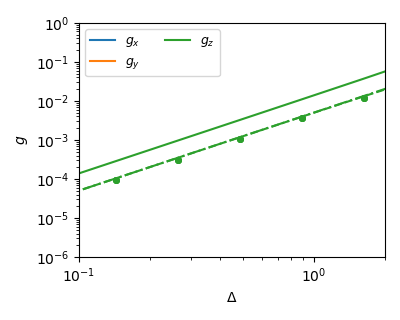

In [94]:
fig, ax1 = plt.subplots(figsize =np.array([5,4])*0.8, dpi=100)
linestyles = ['-', '--','-.' ]
colors = figs.generate_colors_from_colormap(10, 'tab10')
set_label  = True
for i, Pauli in enumerate([Pauli_p1, Pauli_p2, Pauli_SWT]):
    # if i==0 or i==2:
    # if i==0 or i==1:
    #     continue

    σx = np.abs(Pauli[:, 1])
    σy = np.abs(Pauli[:, 2])
    σz = np.abs(Pauli[:, 3])

    ax1.plot(Δ_values, σx, color = colors[0], linestyle=linestyles[i], label = r'$g_{x}$')
    ax1.plot(Δ_values, σy, color = colors[1], linestyle=linestyles[i], label = r'$g_{y}$')
    ax1.plot(Δ_values, σz, color = colors[2], linestyle=linestyles[i], label = r'$g_{z}$')

    # ax1.plot(Δ_values, g_x_pert , '*', color = colors[0], marker='o', markersize='4')
    ax1.plot(Δ_values, np.abs(g_z_pert) , '*', color = colors[2], marker='o', markersize='4')
    # ax1.plot(Δ_values, np.abs(g_zz_pert) , '*', color = colors[2], marker='o', markersize='4')
    # ax1.plot(Δ_values, g_yy_pert , '*', color = colors[1],  markersize='4')

    if set_label:
        set_label =False
        ax1.legend(ncol=2, fontsize=9)

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim([1e-6,1e0])
ax1.set_xlim([1e-3,2])
ax1.set_xlim(left=1e-1)
ax1.set_ylabel('$g$')
ax1.set_xlabel('$\Delta$')

# fig.suptitle(r' --- P1 $\quad$ - - P2 $\quad$ $\cdots$ SWT')
fig.tight_layout()
# figs.export('g_H_eff_vs_Delta.pdf', fig)
fig.show()

In [76]:
g_z_pert / σz

C:\Users\gabri\AppData\Local\Temp\ipykernel_13348\1607663660.py:1: RuntimeWarning: divide by zero encountered in divide
  g_z_pert / σz


array([-inf, -1.281901089252, -0.987798676926, -0.924707042647, -0.907453484672, -0.902443425226, -0.900962786097, -0.900522959056, -0.900392319266, -0.900354045295, -0.900344673586, -0.900348679691, -0.900372702709, -0.900456698534, -0.900741478313, -0.901717168240, -0.905212026975,
       -0.919681362413, -1.015856880344, 0.177571588383])

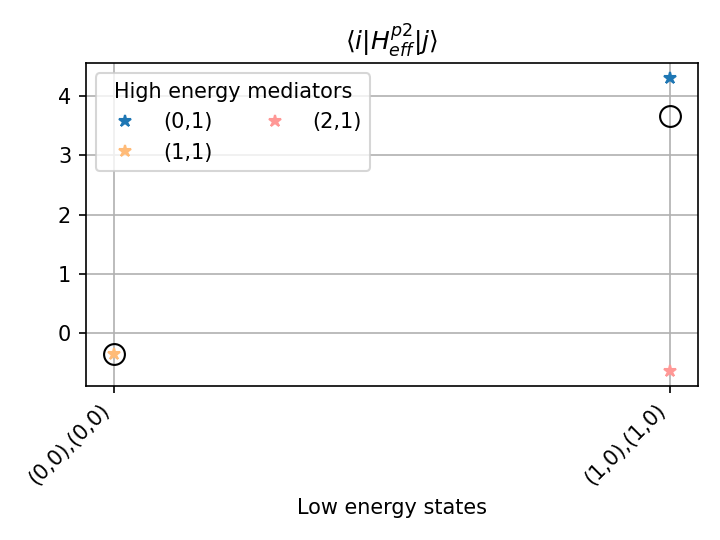

In [174]:
sq_ext.plot_second_order_contributions(H_eff_p2_decomposed, labels_low, labels_high,figsize=np.array([4,3]) * 1.2 ,threshold =1e-4)